# Homework project for the "Differential Equations" course module

by Sercan Hüsnügil

In this project, we aim to demonstrate how to utilize `julia` for solving differential equations. Specifically, we focus on the wave equation and some of its properties. We make extensive use of the code implemented in lectures by Erik Schnetter (https://pirsa.org/C23003).

The wave equation in 1 time + 1 spatial dimensions can be expressed as

\begin{equation}
\frac{du}{dt} = \frac{1}{c^2} \frac{du}{dx}
\end{equation}
where $u=u(t,x)$ is a function and the parameter $c$ is the velocity of the wave.

In the remaining of this project, we assume $c=1$.

## Problem 1

1. Solve the wave equation `dt^2 u(t,x) = dx^2 u(t,x)` numerically. Use a `1+1`-dimensional domain, and use Dirichlet boundary conditions `u(t,-L) = u(t,+L) = 0`. Use the spatial domain bounds `[-1; +1]`, and use the Gaussian-like function `f(t,x) = A exp(-1/2 sin(2pi (x-t))^2 / W^2)` as initial condition. Use `L=1, A=1, W=0.2` as parameters. Evolve from `t=0` to `t=4L`, i.e. for two crossing times. Plot the result.

To solve the wave equation numerically, we will write down functions to create a coordinate grid, to evolve the wave at each point, and to form the initial condition.

First, we start by forming the grids for time and space coordinates.


In [1]:
# Define the grid we want to work on. 
function coords(targs, xargs)
    """
    Returns (ni x nn) matrices for coordinates t and x.
    
    - targs = (tstart, tend, dt)
    -- tstart: starting value for t coordinate
    -- tend: send value for t coordinate
    -- dt: step size in t coordinate
    - xargs = (xstart, xend, dx)
    -- xstart: starting value for x coordinate
    -- xend: send value for x coordinate
    -- dx: step size in x coordinate
    
    """
    tstart = targs[1]; tend = targs[2]; dt = targs[3] 
    xstart = xargs[1]; xend = xargs[2]; dx = xargs[3] 
    
    nn = (tend-tstart)/dt # number of points in t coordinate
    ni = (xend-xstart)/dx # number of points in x coordinate
    
    t = [tstart + n * dt for i in 0:ni, n in 0:nn]
    x = [xstart + i * dx for i in 0:ni, n in 0:nn]
    return t, x
end

coords (generic function with 1 method)

Now, we want to define the functions to evolve a wave with respect to the wave equation and Dirichlet boundary conditions. Following the code implemented in the lectures, we define:

In [2]:
# Find the solution at one interior point
function evolve_point!(u, dt, dx, n, i)
    """
    Evolves the single point u[i,n] in the wave function u using the wave equation, implmeneting the central derivative method.
    -u: wave function
    -dt: step size in t coordinate
    -dx: step size in t coordinate
    -n, i: indices of the point u[i,n]
    """
    ni, nn = size(u)
    # Finite difference for second derivative in x direction
    uxx = (u[i-1,n-1] - 2*u[i,n-1] + u[i+1,n-1]) / dx^2
    # Sove for u[i,n]
    u[i,n] = uxx*dt^2 - u[i,n-2] + 2*u[i,n-1]
    return
end

# Find the soolution for one point in time 'n'
function evolve_step!(u, dt, dx, n)
    """
    Evolves every x coordinate in the wave function u using the wave equation for a single t value u[;,n].
    -u: wave function
    -dt: step size in t coordinate
    -dx: step size in t coordinate
    -n: index of the t value u[;,n]
    """
    ni, nn = size(u)
    # Apply boundary condition at left boundary
    u[1,n] = 0 # Dirichlet
    # Evolve interior
    for i in 2:ni-1
        evolve_point!(u, dt, dx, n, i)
    end
    # Apply boundary condition at right boundary
    u[ni,n] = 0 # Dirichlet
    return
end

function evolve!(u, dt, dx)
    """
    Evolves every point in the wave function for all t coordinates.
    -u: wave function
    -dt: step size in t coordinate
    -dx: step size in t coordinate
    """
    ni, nn = size(u)
    # Loop over all times
    for n in 3:nn
        evolve_step!(u, dt, dx, n)
    end
    return
end

evolve! (generic function with 1 method)

Finally, we define the Gaussian initial condition.

In [3]:
function gaussian(t, x, A, W)
   """
    Returns a Gaussian-like wave function described in the problem.
    -t: grid of time coordinates
    -x: grid of x coodinates
    -A: amplitude of the wave
    -W: width of the Gaussian
   """
    
    ni, nn = size(t)
    u = zeros(ni, nn)
    # Initial condition for the first point in time.
    for n in 1:2, i in 1:ni
        u[i, n] = A * exp.(-1/2 * sin.(2π*(x[i,n]-t[i,n])).^2/W^2)
    end
    return u
end

gaussian (generic function with 1 method)

We use the functions defined above to solve the wave equation for a Gaussian-like initial conidition and imposing Dirichlet boundary conditions.

In [4]:
using CairoMakie

In [5]:
# Given parameters
L = 1 # length in the x coordinate
A = 1 # initial wave amplitude
W = 0.2 # initial wave width

# Form the coordinates
tstart = 0; tend = 4*L; dt = 0.01; targs = (tstart,tend,dt);
xstart = -1; xend = +1; dx = 0.01; xargs = (xstart,xend,dx);

t, x = coords(targs,xargs);

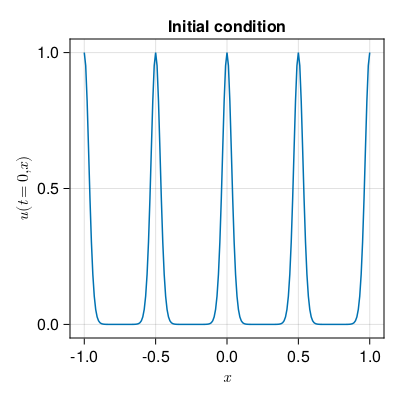

In [6]:
# Form the initial condition and plot the spectrum as a sanity check.
u = gaussian(t, x, A, W);

fig = Figure(resolution = (400, 400))

ax = Axis(fig[1, 1], xlabel=L"x", ylabel=L"u(t=0, x)")
ax.title = "Initial condition"
plt = lines!(x[1:size(x,1),1], u[1:end, 1])
fig

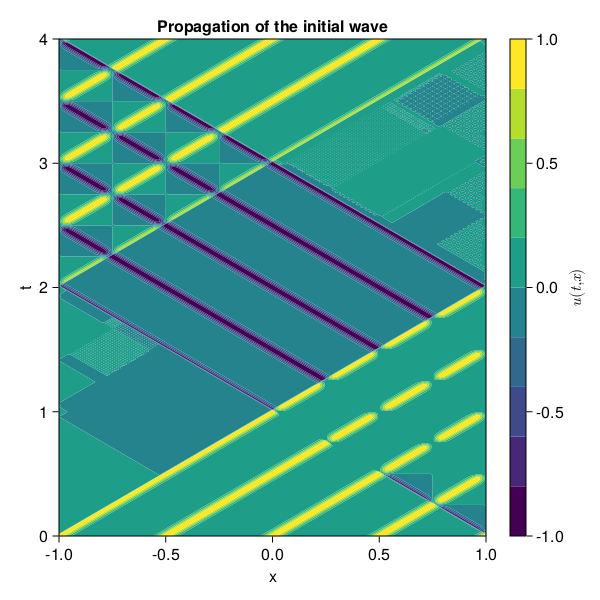

In [7]:
# Evolve the wave and plot the grid.
evolve!(u,dt,dx)
fig = Figure(resolution = (600, 600))
ax = Axis(fig[1, 1], xlabel= "x", ylabel="t")
ax.title = "Propagation of the initial wave"
ctf = contourf!(vec(x), vec(t), vec(u))
Colorbar(fig[1, 2],ctf, label=L"u(t,x)")
fig

We observe that four Gaussian-like waves evolve in time and reflect from the domain walls because of Dirichlet boundary conditions.

## Problem 2

2. Vary the time step size `dt`. If you choose `dt` too large, the discrete system will be unstable. What is the stability limit? Why does this happen? How could you avoid this limit?

We try different values of ``dt`` and plot the resulting graphs using the code from Problem 1.

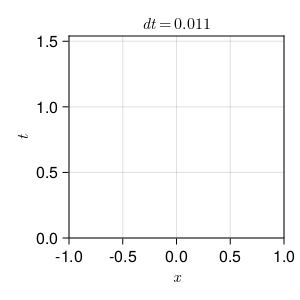

In [8]:
# Use parameters from Problem 1
L = 1 # length in the x coordinate
A = 1 # initial wave amplitude
W = 0.2 # initial wave width

# Input dt and dx values
dt = 0.011; 
dx = 0.01; 

# Form the coordinates
tstart = 0; tend = 4*L; targs = (tstart,tend,dt); 
xstart = -1; xend = +1; xargs = (xstart,xend,dx);
t, x = coords(targs,xargs); # coordinate grid

u = gaussian(t, x, A, W); # initial conditions

# Evolve the wave and plot the grid.
evolve!(u,dt,dx)
fig = Figure(resolution = (300, 300))
ax = Axis(fig[1, 1], xlabel= L"x", ylabel=L"t")
ax.title = L"dt = 0.011"
ctf = contourf!(vec(x), vec(t), vec(u))
fig

The way that we implement the coordinate grid, increasing ``dt`` fro ``0.01`` to even ``0.011`` results in an instability. To get around this instability, one can also adjust the total length of t coordinate such that the number of points along t axis changes accordingly. Still, however, the robust solution seems to be settin ``dt = dx`` whenever ``dt`` is changed. This allows the code to generate a plot without returning an empty grid. An example is shown below:

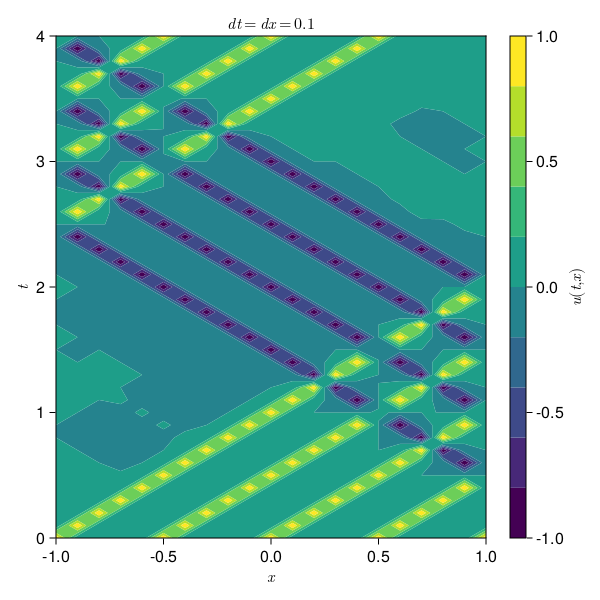

In [9]:
# Use parameters from Problem 1
L = 1 # length in the x coordinate
A = 1 # initial wave amplitude
W = 0.2 # initial wave width

# Input dt and dx values
dt = 0.1; 
dx = dt; 

# Form the coordinates
tstart = 0; tend = 4*L; targs = (tstart,tend,dt); 
xstart = -1; xend = +1; xargs = (xstart,xend,dx);
t, x = coords(targs,xargs); # coordinate grid

u = gaussian(t, x, A, W); # initial conditions

# Evolve the wave and plot the grid.
evolve!(u,dt,dx)
fig = Figure(resolution = (600, 600))
ax = Axis(fig[1, 1], xlabel= L"x", ylabel=L"t")
ax.title = L"dt=dx=0.1"
ctf = contourf!(vec(x), vec(t), vec(u))
Colorbar(fig[1, 2],ctf, label=L"u(t,x)")
fig

Of course, increasing the step sizes ``dt=dx`` too much results in more and more coarse-graded grids. If we increase the value from ``dx=dt=0.1`` to ``0.2``, the plot no longer makes physical sense.  

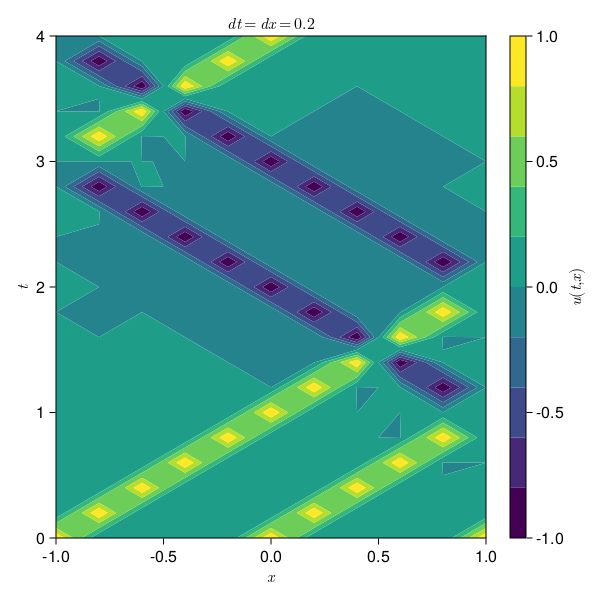

In [10]:
# Use parameters from Problem 1
L = 1 # length in the x coordinate
A = 1 # initial wave amplitude
W = 0.2 # initial wave width

# Input dt and dx values
dt = 0.2; 
dx = dt; 

# Form the coordinates
tstart = 0; tend = 4*L; targs = (tstart,tend,dt); 
xstart = -1; xend = +1; xargs = (xstart,xend,dx);
t, x = coords(targs,xargs); # coordinate grid

u = gaussian(t, x, A, W); # initial conditions

# Evolve the wave and plot the grid.
evolve!(u,dt,dx)
fig = Figure(resolution = (600, 600))
ax = Axis(fig[1, 1], xlabel= L"x", ylabel=L"t")
ax.title = L"dt=dx=0.2"
ctf = contourf!(vec(x), vec(t), vec(u))
Colorbar(fig[1, 2],ctf, label=L"u(t,x)")
fig

Even the initial value is no longer generated as four Gaussian-like waves. Therefore, with ``dt=dx=0.2`` we can say that the numerical implementation no longer describes the physical picture we wish to investigate.

## Problem 3

3. The energy density of a scalar wave is `epsilon(t,x) = 1/2 ((d/dt u(t,x))^2 + ((d/dx u(t,x))^2)`. Calculate the energy density as a function of space and time for your solution. Plot the result.

Energy density is defined as

\begin{equation}
    \epsilon(t,x) = \frac{1}{2} \left(  \left(\frac{du}{dt}\right)^2 + \left(\frac{du}{dx}\right)^2 \right)
\end{equation}

We write the following function to calculate the energy density:

In [11]:
function energy_density(u,dx,dt)
   """
    Returns the energy density of the wavefunction u at each point on the grid.
    -u: wave function
    -dx: step size in x coordinate
    -dt: step size in t coordinate
   """
    ni, nn = size(u)
    
    # Calculate t derivative at each point
    u_dt = zeros(ni,nn)
    for i in 1:ni
        
        u_dt[i,1] = (u[i,2] - u[i,1]) / dt # forward derivative (first order method)
        
        for n in 2:nn-1
            u_dt[i,n] = (u[i,n+1] - 2*u[i,n] + u[i,n-1]) / dt^2 # center derivative (second order method)
        end
        
        u_dt[i,nn] =  (u[i,nn] - u[i,nn-1]) / dt # forward derivative (first order method)
        
    end
    
    # Calculate x derivative at each point
    u_dx = zeros(ni,nn)
    for n in 1:nn
        
        u_dt[1,n] = (u[2,n] - u[1,n]) / dx # forward derivative (first order method)
        
        for i in 2:ni-1
            u_dt[i,n] = (u[i+1,n] - 2*u[i,n] + u[i-1,n]) / dx^2 # center derivative (second order method)
        end        
        
        u_dt[ni,n] =  (u[ni,n] - u[ni-1,n]) / dx # forward derivative (first order method)
        
    end
    
    # Calculate the energy density
    ϵ = 1/2 * (u_dt.^2 .+ u_dx.^2) 
    
    return ϵ./sum(ϵ) # return normalized energy density
end

energy_density (generic function with 1 method)

As can be seen from the function, we use central derivative method for inner points and forward or backward derivative method for points on the edge of the grid. Furthermore, we normalize the values of energy density such that values in the entire grid add up to 1. 

Below, we plot the energy density using the function from Problem 1. We decrease the width of the initial wave to `W = 0.05` after trying different values to get an optimum plot.

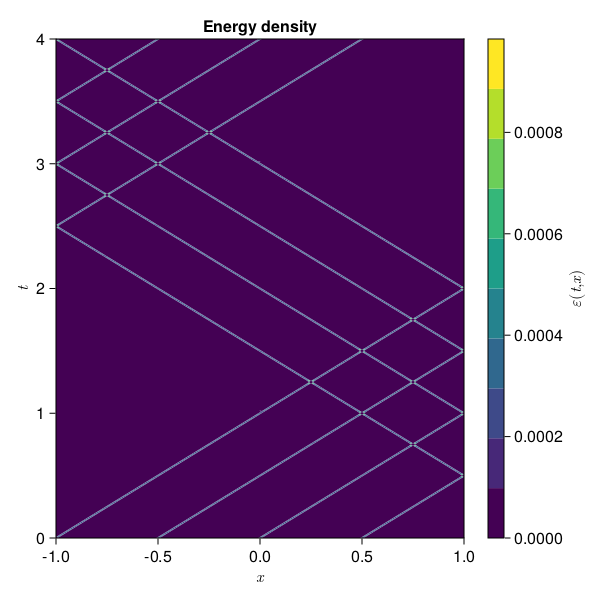

In [12]:
# Use parameters from Problem 1
L = 1 # length in the x coordinate
A = 1 # initial wave amplitude
W = 0.05 # initial wave width

# Input dt and dx values
dt = 0.01; 
dx = 0.01; 

# Form the coordinates
tstart = 0; tend = 4*L; targs = (tstart,tend,dt); 
xstart = -1; xend = +1; xargs = (xstart,xend,dx);
t, x = coords(targs,xargs); # coordinate grid

u = gaussian(t, x, A, W); # initial conditions

# Evolve the wave and plot the grid.
evolve!(u,dt,dx)
# Calculate and plot the energy density
ϵ = energy_density(u,dx,dt)
fig = Figure(resolution = (600, 600))
ax = Axis(fig[1, 1], xlabel= L"x", ylabel=L"t")
ax.title = "Energy density"
ctf = contourf!(vec(x), vec(t), vec(ϵ))
Colorbar(fig[1, 2],ctf, label=L"ϵ(t,x)")
fig

As expected, values of energy density are high at the peaks of the Gaussian-like wave. Furthermore, when the waves are reflected from the boundaries or cross each other they interfere for a short amount of time, resulting a higher value of energy density.

## Problem 4

4. To calculate the total energy `E(t)` as a function of time, you need to integrate it over space. One way to do so is using the function below. Calculate and show the total energy `E(t)` as a function of time. How well is the energy conserved? How does this depend on the grid spacings `dx` and `dt`?

In [13]:
# Integrate `epsilon` over space
function integrate(epsilon, n, dx)
    ni, nt = size(epsilon)
    # The boundary points are special; they have a weight of 1/2.
    # There are `ni` points overall, and the grid spacing is `dx = 2L/(ni-1)`.
    # Integrating the constant function `epsilon=1` thus gives exactly `2L`.
    E = epsilon[1, n] / 2
    for i in 2:ni-1
        E += epsilon[i, n]
    end
    E += epsilon[ni, n] / 2
    return E
end

integrate (generic function with 1 method)

Below, we use the `integrate` function given in the problem and calculate it for each time step.

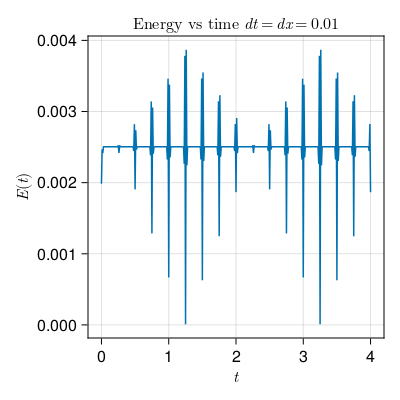

In [17]:
# Use parameters from Problem 1
L = 1 # length in the x coordinate
A = 1 # initial wave amplitude
W = 0.05 # initial wave width

# Input dt and dx values
dt = 0.01; 
dx = 0.01; 

# Form the coordinates
tstart = 0; tend = 4*L; targs = (tstart,tend,dt); 
xstart = -1; xend = +1; xargs = (xstart,xend,dx);
t, x = coords(targs,xargs); # coordinate grid

u = gaussian(t, x, A, W); # initial conditions

# Evolve the wave and plot the grid.
evolve!(u,dt,dx)
# Calculate and plot the energy density
ϵ = energy_density(u,dx,dt)
# Calculate E for each time value
ni, nt = size(u)
E_t = zeros(nt)
for n in 1:nt
    E_t[n] = integrate(ϵ, n, dx)
end
# Plot the result
fig = Figure(resolution = (400, 400))
ax = Axis(fig[1, 1], xlabel= L"t", ylabel=L"E(t)")
ax.title = L"Energy vs time $dt=dx=0.01$"
lns = lines!(t[1,1:end], vec(E_t))
fig

We see some oscillations in the value of `E(t)`. The deviations from the constant value are especially prominent at the time values where the waves reflect from the boundaries or intersect with each other. This effect is expected since we are implementing finite difference methods.

If we decrease the step size in both `t` and `x` we find: 

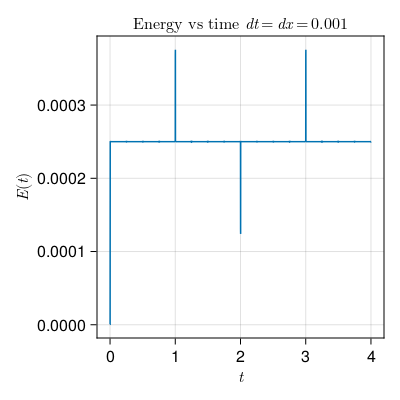

In [28]:
# Use parameters from Problem 1
L = 1 # length in the x coordinate
A = 1 # initial wave amplitude
W = 0.05 # initial wave width

# Input dt and dx values
dt = 0.001; 
dx = 0.001; 

# Form the coordinates
tstart = 0; tend = 4*L; targs = (tstart,tend,dt); 
xstart = -1; xend = +1; xargs = (xstart,xend,dx);
t, x = coords(targs,xargs); # coordinate grid

u = gaussian(t, x, A, W); # initial conditions

# Evolve the wave and plot the grid.
evolve!(u,dt,dx)
# Calculate and plot the energy density
ϵ = energy_density(u,dx,dt)
# Calculate E for each time value
ni, nt = size(u)
E_t = zeros(nt)
for n in 1:nt
    E_t[n] = integrate(ϵ, n, dx)
end
# Plot the result
fig = Figure(resolution = (400, 400))
ax = Axis(fig[1, 1], xlabel= L"t", ylabel=L"E(t)")
ax.title = L"Energy vs time $dt=dx=0.001$"
lines!(t[1,1:end], vec(E_t))
fig

Apart from the initial step in time and the `t` values at which multiple waves reflect from the bounrdary or intersect the energy seems to be constant. Therefore, decreasing the time step decreased the fluctuations in the energy as expected.

To test the opposite case, we also run the same code with a larger time step `dt = dx = 0.1; `.

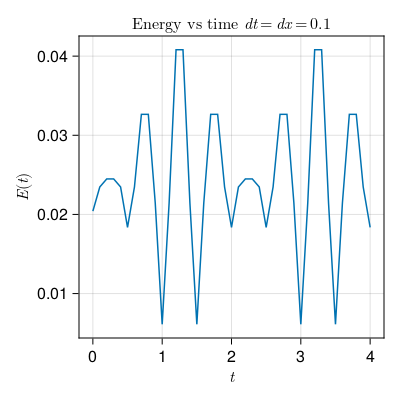

In [16]:
# Use parameters from Problem 1
L = 1 # length in the x coordinate
A = 1 # initial wave amplitude
W = 0.05 # initial wave width

# Input dt and dx values
dt = 0.1; 
dx = 0.1; 

# Form the coordinates
tstart = 0; tend = 4*L; targs = (tstart,tend,dt); 
xstart = -1; xend = +1; xargs = (xstart,xend,dx);
t, x = coords(targs,xargs); # coordinate grid

u = gaussian(t, x, A, W); # initial conditions

# Evolve the wave and plot the grid.
evolve!(u,dt,dx)
# Calculate and plot the energy density
ϵ = energy_density(u,dx,dt)
# Calculate E for each time value
ni, nt = size(u)
E_t = zeros(nt)
for n in 1:nt
    E_t[n] = integrate(ϵ, n, dx)
end
# Plot the result
fig = Figure(resolution = (400, 400))
ax = Axis(fig[1, 1], xlabel= L"t", ylabel=L"E(t)")
ax.title = L"Energy vs time $dt=dx=0.1$"
lines!(t[1,1:end], vec(E_t))
fig

As we can see, the flucutations in the energy values are much more prominent when we used larger time steps.